**WELCOME ALL In this Notebook I use DistillBERT-Squad model**                                           

* Question----> the sentiment given in the dataset(postive/negative/neutral)
* Context-----> the text/tweet given in the dataset
* Answer---->the selected_text column in the training datset, and also we need the starting index of the answer(selected_text) in the text(tweet) 

This all should be in a json format which is required by distilBERT to train


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
train_df=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
import torch
#!pip install transformers
from transformers import BertForQuestionAnswering

#model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

question_p="positive sentence? "
question_n="negative sentence?"
question_neu="neutral sentence? " 

HERE i just change the terms positive,negative,neutral into questions in the train data

In [ ]:
def make_question(x):
    if x=="positive":
        return question_p
    elif x=="negative":
        return question_n
    else:
        return question_neu
    
train_df["sentiment"]=train_df["sentiment"].apply(make_question)
train_df["sentiment"]

In [ ]:
train_df=train_df.dropna()

HERE I find the indices (start) of the selected_text from Text column and create a new column called answer_index

In [ ]:
def answer_index(x):
    return x["text"].find(str(x["selected_text"]))
train_df["answer_index"]=train_df.apply(answer_index,axis=1)

In [ ]:
train_df.head()


This big function below will make the training data suitable in the form of 
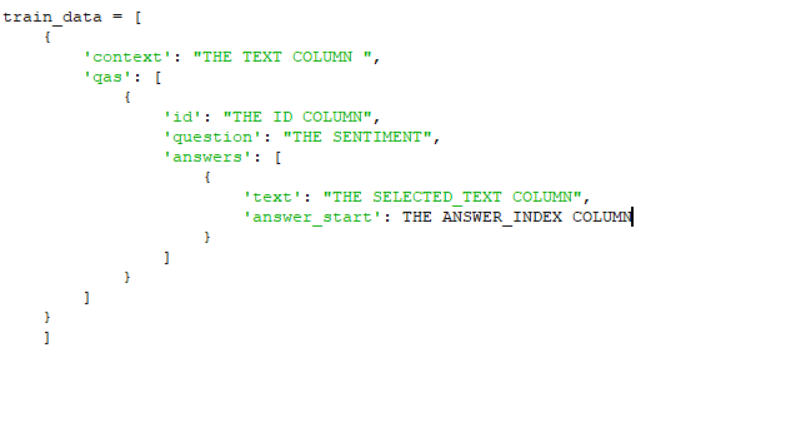

In [ ]:
train_data=[]
def make_train_data(df):
    
    
    for ind in df.index:
        main_d=dict()
        context=df.loc[ind,"text"].lower()
        main_d["context"]=context
        qas=[]
        inside_qas={}
        inside_qas["id"]=df.loc[ind,"textID"]
        inside_qas["question"]=df.loc[ind,"sentiment"]
        inside_answer=[{"text":df.loc[ind,"selected_text"].lower(),"answer_start": int(df.loc[ind,"answer_index"])}]
        inside_qas["answers"]=inside_answer
        inside_qas["is_impossible"]=False
        qas.append(inside_qas)
        main_d["qas"]=qas
        train_data.append(main_d)
    return train_data
        
    
    
    
    
    
    
    
    


In [ ]:

train_data=make_train_data(train_df)

In [ ]:
train_df

HERE we convert it into json format and we shall be ready for the training

In [ ]:
import json
#train_data_json=json.dumps(train_data)
with open('/kaggle/working/train.json', 'w') as outfile:
    json.dump(train_data, outfile)


    **Here I would like to thank Mr Jonathan Besomi https://www.kaggle.com/jonathanbesomi/question-answering-starter-pack for the inspiration of using distilbert and that too without internet he as explained very nicely please do upvote it :D **

In [ ]:
!pip install '/kaggle/input/simple-transformers-pypi/seqeval-0.0.12-py3-none-any.whl' -q
!pip install '/kaggle/input/simple-transformers-pypi/simpletransformers-0.22.1-py3-none-any.whl' -q


from simpletransformers.question_answering import QuestionAnsweringModel
MODEL_PATH = '/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/'

model=QuestionAnsweringModel("distilbert",MODEL_PATH,
                               args={'reprocess_input_data': True,
                                     'overwrite_output_dir': True,
                                     'learning_rate': 5e-5,
                                     'num_train_epochs': 2,
                                     'max_seq_length': 128,
                                     'doc_stride': 64,
                                     'fp16': False,
                                    },
                              use_cuda=True)


In [ ]:
model.train_model('/kaggle/working/train.json')

WE USE THE SAME FUNCTION FOR TRANSFORMING TRAINING DATA EXCEPT COMMENT SOME PARTS AS BELOW

In [ ]:
test_data=[]

def make_test_data(df):
    
    
    for ind in df.index:
        main_d=dict()
        context=df.loc[ind,"text"].lower()
        main_d["context"]=context
        qas=[]
        inside_qas={}
        inside_qas["id"]=df.loc[ind,"textID"]
        inside_qas["question"]=df.loc[ind,"sentiment"]
        #inside_answer=[{"text":df.loc[ind,"selected_text"].lower(),"answer_start": int(df.loc[ind,"answer_index"])}]
        #inside_qas["answers"]=inside_answer
        inside_qas["is_impossible"]=False
        qas.append(inside_qas)
        main_d["qas"]=qas
        test_data.append(main_d)
    return test_data
        

In [ ]:
test_df=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
test_df["sentiment"]=test_df["sentiment"].apply(make_question)

test_data=make_test_data(test_df)

test_data_json=json.dumps(test_data)
with open('/kaggle/working/test.json', 'w') as outfile:
    json.dump(test_data, outfile)

BADA_BING_BADA_BORE WE PREDICT AND HOPE FOR A GOOD SCORE :D

In [ ]:
predictions=model.predict(test_data)

In [ ]:
predictions_df = pd.DataFrame.from_dict(predictions)
sub_df=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")
sub_df['selected_text'] = predictions_df['answer']

sub_df.to_csv('submission.csv', index=False)